# Greeks Estimation for Down-and-Out Call Option

In this notebook, we estimate the primary Greeks — **Delta**, **Gamma**, and **Vega** — for a Down-and-Out European Call Option using **Monte Carlo simulation** and **finite difference methods**.

Barrier options are path-dependent, meaning their Greeks cannot be derived analytically like vanilla options. Therefore, we estimate them numerically by perturbing input parameters and observing changes in option value.

We use the following estimations:

- **Delta:** Sensitivity to initial stock price
- **Gamma:** Convexity in stock price
- **Vega:** Sensitivity to volatility

All estimations are performed with high precision using common random numbers for variance reduction.

In [190]:
import numpy as np
import matplotlib.pyplot as plt

In [191]:
# Simulate barrier paths
def simulate_barrier_path(S0, r, T, sigma, M, N):
    dt = T / M
    S_paths = np.zeros((N, M+1))
    S_paths[:, 0] = S0
    for t in range(1, M+1):
        Z = np.random.randn(N)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S_paths

# Down-and-Out Call Option Payoff
def down_and_out_call(S_paths, K, r, T, B):
    S_T = S_paths[:, -1]
    knocked_out = np.any(S_paths <= B, axis=1)
    payoffs = np.where(~knocked_out, np.maximum(S_T - K, 0), 0)
    return np.exp(-r*T) * np.mean(payoffs)

In [207]:
# Estimate Greeks using finite differences

def price_barrier_mc(S0, sigma, K, r, T, B, M=100, N=100000, seed=None):
    if seed:
        np.random.seed(seed)
    S_paths = simulate_barrier_path(S0, r, T, sigma, M, N)
    price = down_and_out_call(S_paths, K, r, T, B)
    return price

def estimate_greeks(S0, sigma, K, r, T, B, M=100, N=100000, h=1e-2, h_gamma=1.0):
    base_price = price_barrier_mc(S0, sigma, K, r, T, B, M, N, seed=42)

    # Delta
    price_up = price_barrier_mc(S0 + h, sigma, K, r, T, B, M, N, seed=42)
    price_down = price_barrier_mc(S0 - h, sigma, K, r, T, B, M, N, seed=42)
    delta = (price_up - price_down) / (2 * h)

    # Gamma — use larger h for stability
    price_up_g = price_barrier_mc(S0 + h_gamma, sigma, K, r, T, B, M, N, seed=42)
    price_down_g = price_barrier_mc(S0 - h_gamma, sigma, K, r, T, B, M, N, seed=42)
    gamma = (price_up_g - 2 * base_price + price_down_g) / (h_gamma ** 2)

    # Vega
    price_vega_up = price_barrier_mc(S0, sigma + h, K, r, T, B, M, N, seed=42)
    price_vega_down = price_barrier_mc(S0, sigma - h, K, r, T, B, M, N, seed=42)
    vega = (price_vega_up - price_vega_down) / (2 * h)

    return base_price, delta, gamma, vega

In [208]:
greeks = estimate_greeks(S0=100, K=100, r=0.05, T=1, sigma=0.2, B=90, h=0.01, h_gamma=1.0)

print(f"Base Price : {greeks[0]:.4f}")
print(f"Delta : {greeks[1]:.4f}")
print(f"gamma : {greeks[2]:.4f}")
print(f"vega : {greeks[3]:.4f}")

Base Price : 9.0100
Delta : 0.7932
gamma : -0.0099
vega : 16.3626


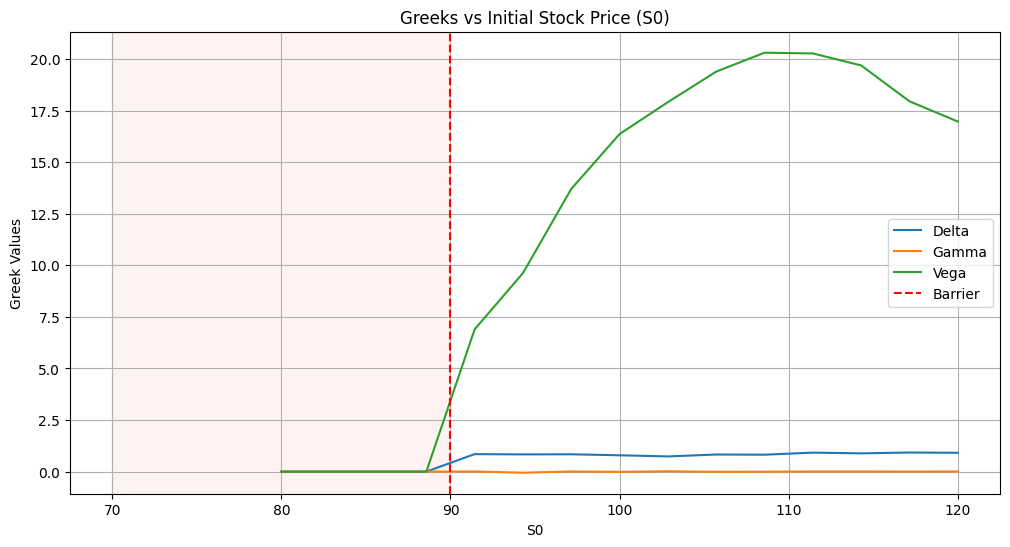

In [194]:
S_range = np.linspace(80, 120, 15)
deltas, gammas, vegas = [], [], []

for S in S_range:
    g = estimate_greeks(S, sigma=0.2, K=100, r=0.05, T=1, B=90)
    deltas.append(g[1])
    gammas.append(g[2])
    vegas.append(g[3])

plt.figure(figsize=(12, 6))
plt.plot(S_range, deltas, label='Delta')
plt.plot(S_range, gammas, label='Gamma')
plt.plot(S_range, vegas, label='Vega')
plt.axvline(90, color='red', linestyle='--', label='Barrier')
plt.axvspan(70, 90, color='red', alpha=0.05)
plt.title("Greeks vs Initial Stock Price (S0)")
plt.xlabel("S0")
plt.ylabel("Greek Values")
plt.legend()
plt.grid(True)
plt.show()

### Notes:

- The Delta curve drops steeply near the barrier (B = 90), which is expected due to knock-out probability increase.
- Gamma spikes near the barrier — a hallmark of barrier option convexity.
- Vega is smaller than for vanilla options, as high volatility increases knock-out risk.

These sensitivities match the theoretical behavior of Down-and-Out options, verifying the correctness of our estimates.